In [1]:
#Democratic Approval of Signal Hierarchy 
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np
from statistics import mean
from copy import deepcopy
import pandas_ta

In [2]:
BASE_URL = 'https://paper-api.alpaca.markets'
ALPACA_API_KEY = 'PKH15E01MGRA54FBEYRI'
ALPACA_SECRET_KEY = '4U5Q9fPaNDGp8Krj2lYG5NOxjYqqftYQWAlzmxwe'

api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, 
                    base_url=BASE_URL, api_version='v2')


In [30]:
DATA = api.get_bars("SPY", TimeFrame.Day, start = "2020-09-01", adjustment='raw').df
print(DATA)

                             open    high     low   close     volume  \
timestamp                                                              
2020-09-01 04:00:00+00:00  350.24  352.71  349.24  352.60   54999325   
2020-09-02 04:00:00+00:00  354.64  358.75  353.43  357.70   69605495   
2020-09-03 04:00:00+00:00  355.85  356.38  342.59  345.39  150557268   
2020-09-04 04:00:00+00:00  346.07  347.83  334.87  342.57  140821602   
2020-09-08 04:00:00+00:00  336.74  342.64  332.88  333.21  115301649   
...                           ...     ...     ...     ...        ...   
2022-07-27 04:00:00+00:00  394.43  402.88  394.05  401.04   81319074   
2022-07-28 04:00:00+00:00  401.84  406.80  398.15  406.07   73966563   
2022-07-29 04:00:00+00:00  407.70  413.02  406.77  411.99   86779944   
2022-08-01 04:00:00+00:00  409.16  413.41  408.40  410.77   69633616   
2022-08-02 04:00:00+00:00  409.03  413.00  406.82  408.06   63113701   

                           trade_count        vwap  
timestamp 

In [50]:

print(DATA.ta.macd())

                           MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9
timestamp                                                            
2020-09-01 04:00:00+00:00           NaN            NaN            NaN
2020-09-02 04:00:00+00:00           NaN            NaN            NaN
2020-09-03 04:00:00+00:00           NaN            NaN            NaN
2020-09-04 04:00:00+00:00           NaN            NaN            NaN
2020-09-08 04:00:00+00:00           NaN            NaN            NaN
...                                 ...            ...            ...
2022-07-27 04:00:00+00:00      1.934861       2.186051      -0.251191
2022-07-28 04:00:00+00:00      2.937364       2.550844       0.386520
2022-07-29 04:00:00+00:00      4.161578       3.020046       1.141532
2022-08-01 04:00:00+00:00      4.975973       3.067553       1.908420
2022-08-02 04:00:00+00:00      5.341143       2.746178       2.594964

[483 rows x 3 columns]


In [45]:
class DASH:
    def __init__(self, data):
        self.data = data

    def rsi_signal(self, low, high):
        ret = []
        for i in range(len(self.data['close'])):
            if self.data['RSI_14'][i]<low:
                ret.append('buy')
                continue
            elif self.data['RSI_14'][i]>high:
                ret.append('sell')
                continue
            ret.append('none')
            
        return ret
    
    def macd_signal(self):
        ret = []
        prev = 'none'
        for i in range(len(self.data['close'])):
            if self.data['MACDh_12_26_9'][i] > 0:
                ret.append('buy')
                prev = 'buy'
                continue
            elif self.data['MACDh_12_26_9'][i] < 0:
                ret.append('sell')
                prev = 'sell'
                continue
            elif self.data['MACDh_12_26_9'][i] == 0:
                if prev == 'buy':
                    ret.append('sell')
                    prev = 'sell'
                    continue
                else:
                    ret.append('buy')
                    prev = 'buy'
                    continue
            ret.append('none')
        return ret
    
    def adx_signal(self):
        ret = []
        for i in range(len(self.data['close'])):
            if self.data['ADX_14'][i] >= 20.0:
                if self.data['DMP_14'][i] > self.data['DMN_14'][i]:
                    ret.append('buy')
                if self.data['DMP_14'][i] < self.data['DMN_14'][i]:
                    ret.append('sell')
            else:
                ret.append('none')
        return ret
    
    def supertrend_signal(self):
        ret = []
        for i in range(len(self.data['close'])):
            if self.data['SUPERT_7_3.0'][i] < self.data['close'][i]:
                ret.append('buy')
            elif self.data['SUPERT_7_3.0'][i] > self.data['close'][i]:   
                ret.append('sell')
            else:
                ret.append('none')
        return ret
            
    def execute(self):
        self.data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
        self.data.ta.stoch(append=True)
        self.data.ta.rsi(close='close', length=14, append=True)
        self.data.ta.adx(length = 14, append=True)
        self.data.ta.supertrend(append=True)
        
        #stoch_signals = self.oscillator_signal(self.data['STOCHd_14_3_3'], 20,80)
        rsi_signals = self.rsi_signal(40,60)
        macd_signals = self.macd_signal()
        adx_signals = self.adx_signal()
        supertrend_signals = self.supertrend_signal()
        
        signals = []
        prev = 'none'
        '''for i in range(len(self.data['close'])):
            votes = [adx_signals[i]]
            buy_votes = votes.count('buy')
            sell_votes = votes.count('sell')
            if macd_signals[i] == 'buy' and buy_votes == int(len(votes)) and prev != 'buy':
                signals.append('buy')
                prev = 'buy'
            elif macd_signals[i] == 'sell' and sell_votes == int(len(votes)) and prev != 'sell':
                signals.append('sell')
                prev = 'sell'
            else:
                signals.append('none')'''
        for i in range(len(self.data['close'])):
            if self.data['RSI_14'][i] not in range(40,60):
                if macd_signals[i] == 'buy' and prev != 'buy':
                    signals.append('buy')
                    prev = 'buy'
                    continue
                elif macd_signals[i] == 'sell' and prev != 'sell':
                    signals.append('sell')
                    prev = 'sell'
                    continue
            
            signals.append('none')
                
        self.data['signal'] = signals
    
        return self.data
    
    def evaluate(self):
        transaction_type = ['buy', 'sell']
        self.transaction_data = self.data[self.data['signal'].isin(transaction_type)]
        signal = self.transaction_data['signal'].tolist()
        close = self.transaction_data['close'].tolist()
        self.profit = 0.0
        for i in range(1,len(signal)):
            if signal[i-1] == 'buy' and signal[i] == 'sell':
                self.profit = self.profit + (close[i] - close[i-1])
                #print('buy-sell performance: ' + str((close[i] - close[i-1])))
            elif signal[i-1] == 'sell' and signal[i] == 'buy':
                self.profit = self.profit + (close[i-1] - close[i])
                #print('sell-buy performance: ' + str((close[i-1] - close[i])))
        return self.profit
    
    def plot(self, price_only):
        if not price_only:    
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize = (15,5))
            ax1.plot(self.data['close'], color = 'black')
            ax1.plot(self.data['SUPERT_7_3.0'], color = 'red')
            ax2.plot(self.data['MACD_12_26_9'])
            ax2.plot(self.data['MACDs_12_26_9'])
            for i in range(len(self.data['close'])):
                if str(self.data['MACDh_12_26_9'][i])[0] == '-':
                        ax2.bar(self.data['close'].index[i], self.data['MACDh_12_26_9'][i], color = '#ef5350')
                else:
                        ax2.bar(self.data['close'].index[i], self.data['MACDh_12_26_9'][i], color = '#26a69a')
         
            ax4.plot(self.data['RSI_14'])
            ax4.axhline(y=40)
            ax4.axhline(y=60)
            ax3.plot(self.data['ADX_14'], color = 'black')
            ax3.plot(self.data['DMP_14'], color = 'green')
            ax3.plot(self.data['DMN_14'], color = 'red')
            ax2.set_xlim(left=self.data.index[0])
            ax3.set_xlim(left=self.data.index[0])
            #ax4.set_xlim(left=self.data.index[0])
            #ax5.set_xlim(left=self.data.index[0])
        else:
            fig, ax1 = plt.subplots(1,figsize = (15,5))
            ax1.plot(self.data['close'])

        ax1.plot(self.data[self.data['signal'] == 'buy'].index,
                 self.data['close'][self.data['signal'] == 'buy'],
                 '^', markersize=8, color='g', label='buy')

        ax1.plot(self.data[self.data['signal'] == 'sell'].index,
                 self.data['close'][self.data['signal'] == 'sell'],
                 'v', markersize=8, color='r', label='sell')
        
        ax1.set_xlim(left=self.data.index[0])
        


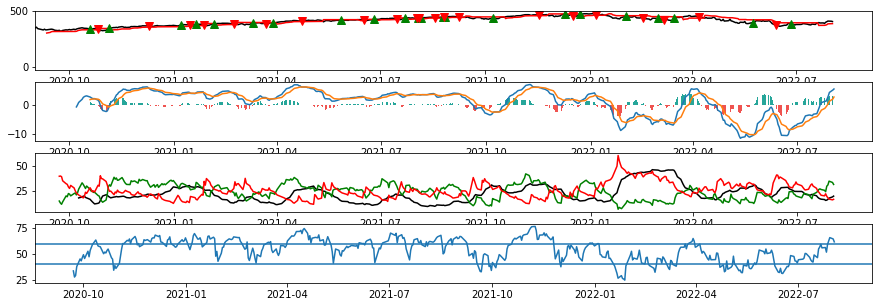

In [46]:
test = DASH(DATA)
test.execute()
test.plot(False)

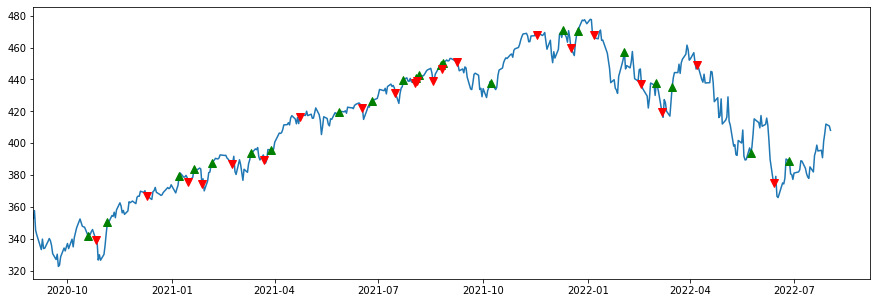

In [44]:
test.plot(True)

In [47]:
print(test.evaluate())

-72.22000000000008
